In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import KFold, StratifiedKFold
import os
import shutil
from tqdm import tqdm
from ship_mrcnn import *
from keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.
/home/kownse/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [21]:
segment = pd.read_csv('../input/train_ship_segmentations_v2.csv.zip')

In [39]:
segment.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [22]:
fold = segment.groupby('ImageId')['EncodedPixels'].agg('count')

In [23]:
fold = fold.reset_index()

In [24]:
fold = fold.rename({'EncodedPixels':'ships'}, axis=1)

In [25]:
fold['has_ship'] = (fold['ships'] > 0) * 1

In [26]:
fold.shape

(192556, 3)

In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

In [28]:
splits = list(skf.split(fold, fold.ships))

In [29]:
fold['fold'] = 0
fold['holdout'] = 0

In [30]:
newfold = []
for idx, f in enumerate(splits):
    train_idx = f[0] 
    val_idx = f[1]
    print('train_idx len:', len(train_idx), 'val_idx len:', len(val_idx))
    fold.iloc[val_idx, 3] = idx
    
    subfold = fold.iloc[val_idx]
    
    sskf = StratifiedKFold(n_splits=30, shuffle=True, random_state=1234)
    st_idx, sv_idx = next(sskf.split(subfold, subfold.ships))
    print('sv_idx len:', len(sv_idx))
    subfold.iloc[sv_idx, 4] = 1
    newfold.append(subfold)

train_idx len: 154039 val_idx len: 38517
sv_idx len: 1291
train_idx len: 154042 val_idx len: 38514


/home/kownse/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 14 members, which is too few. The minimum number of members in any class cannot be less than n_splits=30.
  % (min_groups, self.n_splits)), Warning)
/home/kownse/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/kownse/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 13 members, which is too few. The minimum number of members in any class cannot be less than n_splits=30.
  % (min_groups, self.n_splits)), Warning)


sv_idx len: 1291
train_idx len: 154044 val_idx len: 38512
sv_idx len: 1291
train_idx len: 154047 val_idx len: 38509
sv_idx len: 1291
train_idx len: 154052 val_idx len: 38504
sv_idx len: 1291


In [35]:
subfold.holdout.value_counts()

0    37213
1     1291
Name: holdout, dtype: int64

In [31]:
nf = pd.concat(newfold)

In [37]:
nf.to_csv('../input/folds.csv', index=False)

In [38]:
nf.head()

ImageId  ships  has_ship  fold  holdout
11  000532683.jpg      2         1     0        0
22  000913daf.jpg      0         0     0        0
23  000952d51.jpg      0         0     0        0
24  000969125.jpg      0         0     0        0
25  0009a46e1.jpg      0         0     0        0

In [9]:
folds = pd.read_csv('../input/folds_clean.csv')

train_idx len: 1 val_idx len: 1
train_idx len: 1 val_idx len: 1
train_idx len: 1 val_idx len: 1
train_idx len: 1 val_idx len: 1
train_idx len: 1 val_idx len: 1


In [34]:
len(f)

7

In [38]:
folds.head()

ImageId  ships  has_ship  fold  holdout
0  00003e153.jpg      0         0     2        0
1  000155de5.jpg      1         1     1        1
2  00021ddc3.jpg      9         1     1        0
3  0002756f7.jpg      2         1     0        0
4  0002d0f32.jpg      0         0     1        0

In [4]:
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg']

In [10]:
folds.set_index('ImageId', inplace=True)

In [13]:
for path in exclude_list:
    if path in folds.index:
        folds = folds.drop(path)
        print('dropped', path)

In [14]:
folds.to_csv('../input/folds_clean.csv')

In [16]:
folds.head()

ImageId  ships  has_ship  fold  holdout
0  00003e153.jpg      0         0     2        0
1  000155de5.jpg      1         1     1        1
2  00021ddc3.jpg      9         1     1        0
3  0002756f7.jpg      2         1     0        0
4  0002d0f32.jpg      0         0     1        0

In [28]:
img = cv2.imread('../input/all/0019fc4d8.jpg')

In [3]:
def getpath(row):
    train_path = '../input/train/{}'.format(row.ImageId)
    val_path = '../input/val/{}'.format(row.ImageId)
    if os.path.exists(train_path):
        return train_path
    elif os.path.exists(val_path):
        return val_path
    return None
unique['path'] = unique.apply(getpath, axis=1)

In [4]:
unique.to_csv('../input/unique_img_ids.csv', index=False)

In [5]:
unique.head()

ImageId  ships  has_ship has_ship_vec                          path
0  00003e153.jpg      0       0.0        [0.0]  ../input/train/00003e153.jpg
1  000155de5.jpg      1       1.0        [1.0]  ../input/train/000155de5.jpg
2  00021ddc3.jpg      9       1.0        [1.0]  ../input/train/00021ddc3.jpg
3  0002756f7.jpg      2       1.0        [1.0]  ../input/train/0002756f7.jpg
4  0002d0f32.jpg      0       0.0        [0.0]  ../input/train/0002d0f32.jpg

In [6]:
sample = pd.read_csv('../input/sample_submission.csv.zip')
segment = pd.read_csv('../input/train_ship_segmentations.csv.zip')
sub = pd.read_csv('../result/scored_all_0.600.csv')
blend = pd.read_csv('../result/blended_submission.csv')
hasship = pd.read_csv('../result/hasship.csv')
test_res = pd.read_csv('../input/test_ship_segmentations.csv.zip')

In [11]:
test_res['ships'] = test_res['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

In [14]:
test_res = test_res.groupby('ImageId').agg({'ships': 'sum'}).reset_index()

In [16]:
test_res['has_ship'] = test_res['ships'].map(lambda x: 1.0 if x>0 else 0.0)

In [17]:
test_res['has_ship_vec'] = test_res['has_ship'].map(lambda x: [x])

In [19]:
test_res.to_csv('../input/test_mask.csv', index=False)

In [4]:
hasship.fillna('', inplace=True)
empty_img = hasship.loc[hasship.EncodedPixels=='', 'ImageId'].unique()

sub_check = sub.copy()
sub_check['noship'] = 0
prog = tqdm(total=len(empty_img))
for idx, emp_col in enumerate(empty_img):
    sub_check.loc[sub_check.ImageId == emp_col, 'noship'] = 1
    prog.update(1)

sub_check.EncodedPixels = sub_check.apply(lambda x : x.EncodedPixels if x.noship == 0 else '', axis=1)
sub_check.fillna('', inplace=True)
sub_check.drop_duplicates(inplace=True)
sub_check.drop('noship', axis=1, inplace=True)

100%|█████████▉| 79213/79215 [26:41<00:00, 50.55it/s]

In [5]:
kaggle_util.save_result(sub_check, '../result/sub_noship_all.csv', 
                        competition = 'airbus-ship-detection', 
                        send = True, index = False)

save result
upload result
cmd: kaggle competitions submit -c airbus-ship-detection -f ../result/sub_noship_all.csv.7z -m "submit"


100%|██████████| 79215/79215 [27:00<00:00, 50.55it/s]

In [7]:
def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
            
    print(in_mask_list, len(in_mask_list), 'ships')
    return all_masks

In [10]:
def show_test_result_by_imgid(imgid, test_set, path):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))
    c_img = cv2.imread(os.path.join(path, imgid))
    print(c_img.shape)
    c_img = np.expand_dims(c_img, 0)/255.0
    ax1.imshow(c_img[0])
    ax1.set_title('Image: ' + imgid)
    ax2.imshow(masks_as_color(test_set.query('ImageId==\"{}\"'.format(imgid))['EncodedPixels']))

In [13]:
def show_test_result_bulk(test_set, path, TOP_PREDICTIONS = 2):
    for imgid in test_set.ImageId.unique()[:TOP_PREDICTIONS]:
        show_test_result_by_imgid(imgid, test_set, path)

In [11]:
oof = pd.read_csv('../result/oof_coco_ship_.csv')

(768, 768, 3)
0    NaN
Name: EncodedPixels, dtype: object 1 ships
(768, 768, 3)
1    263142 9 263906 15 264668 22 265435 23 266202 ...
Name: EncodedPixels, dtype: object 1 ships
(768, 768, 3)
2    93688 3 94454 6 95221 8 95989 8 96756 10 97523...
3    67497 8 68263 11 69030 13 69798 13 70566 14 71...
4    73669 7 74437 7 75205 8 75973 8 76741 8 77509 ...
5    138876 3 139640 8 140407 9 141175 9 141943 8 1...
6    148119 1 148886 3 149654 3 150422 4 151190 4 1...
Name: EncodedPixels, dtype: object 5 ships
(768, 768, 3)
7    248874 5 249640 9 250407 12 251175 14 251942 1...
Name: EncodedPixels, dtype: object 1 ships
(768, 768, 3)
8    NaN
Name: EncodedPixels, dtype: object 1 ships
(768, 768, 3)
9    NaN
Name: EncodedPixels, dtype: object 1 ships
(768, 768, 3)
10    348036 5 348801 10 349568 13 350336 14 351104 ...
Name: EncodedPixels, dtype: object 1 ships
(768, 768, 3)
11    566911 7 567677 12 568445 13 569212 14 569980 ...
Name: EncodedPixels, dtype: object 1 ships
(768, 768, 3)
12    

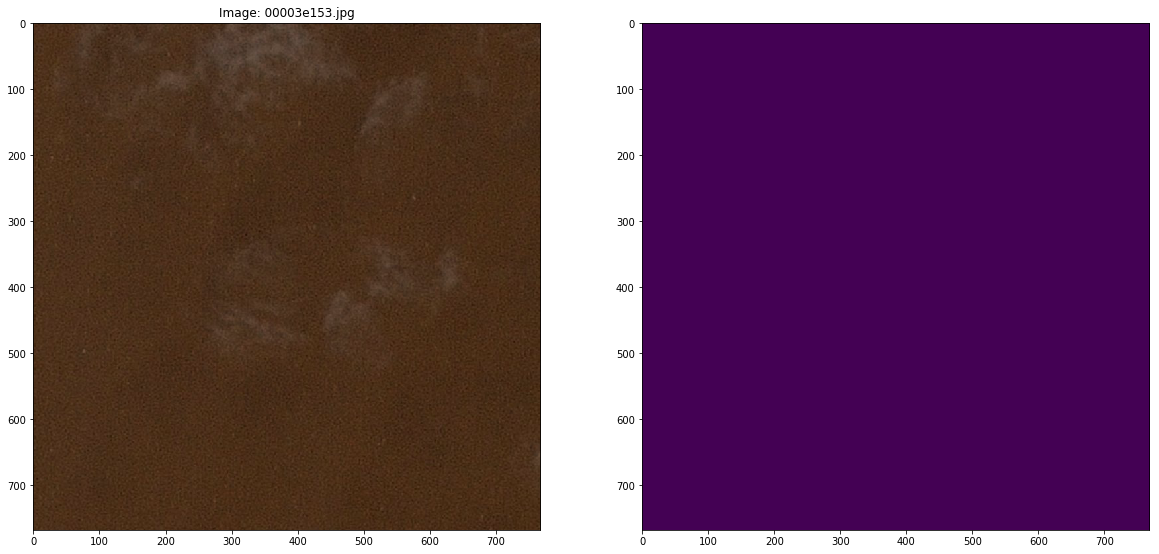

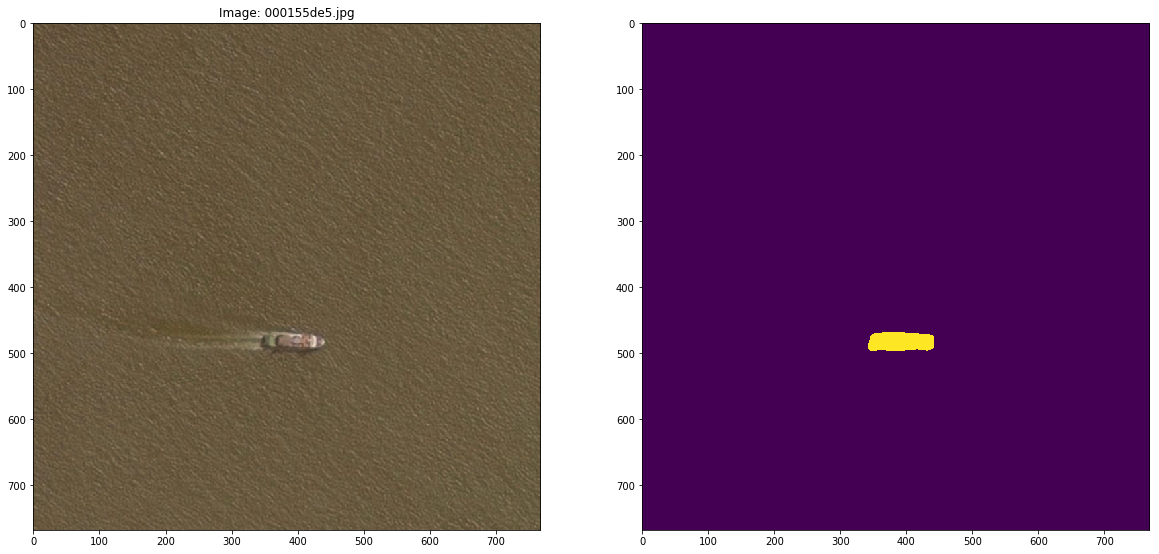

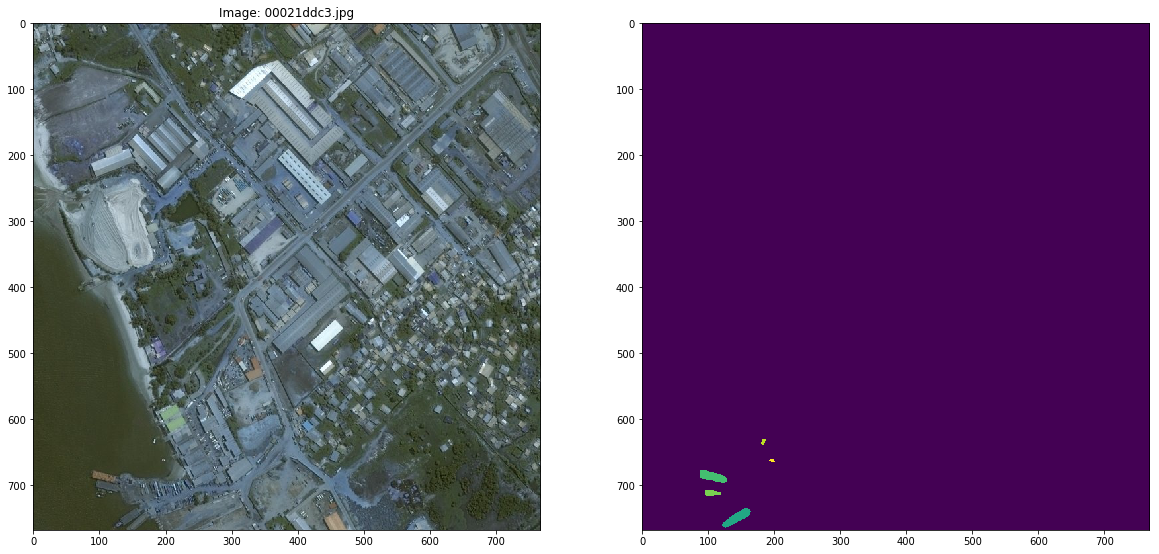

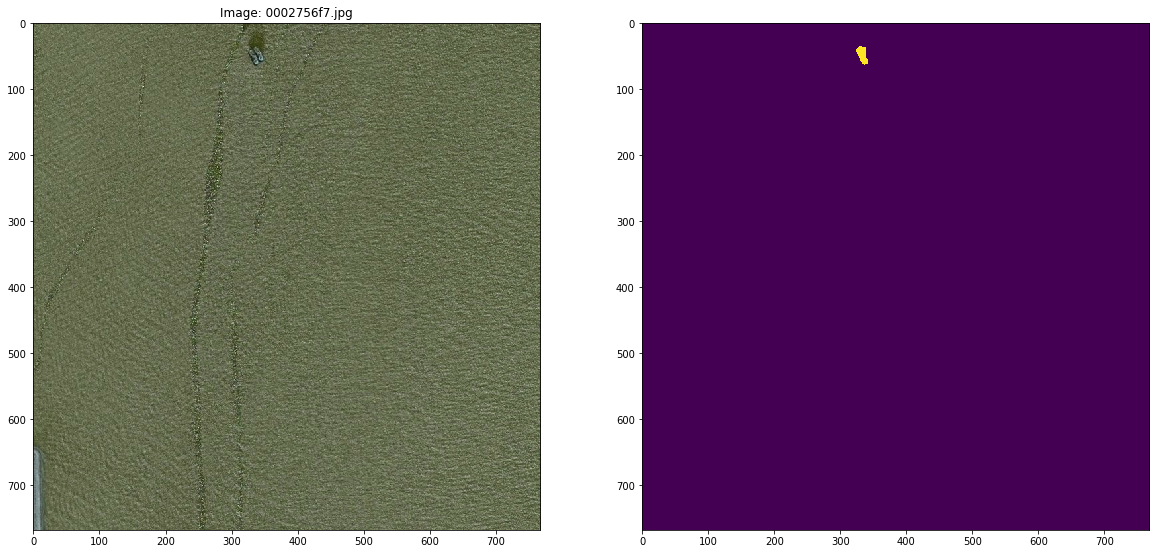

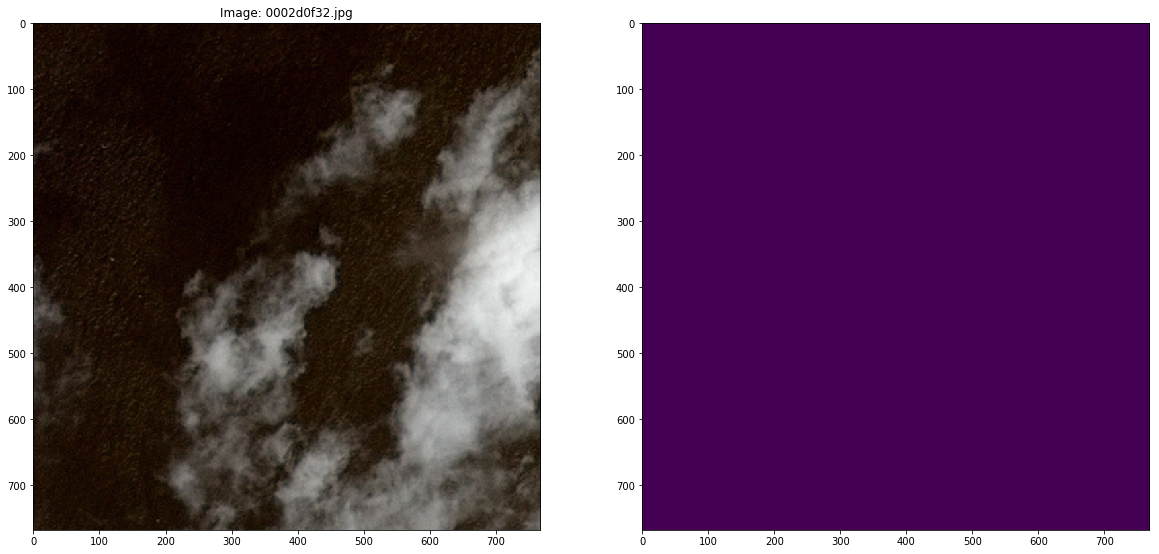

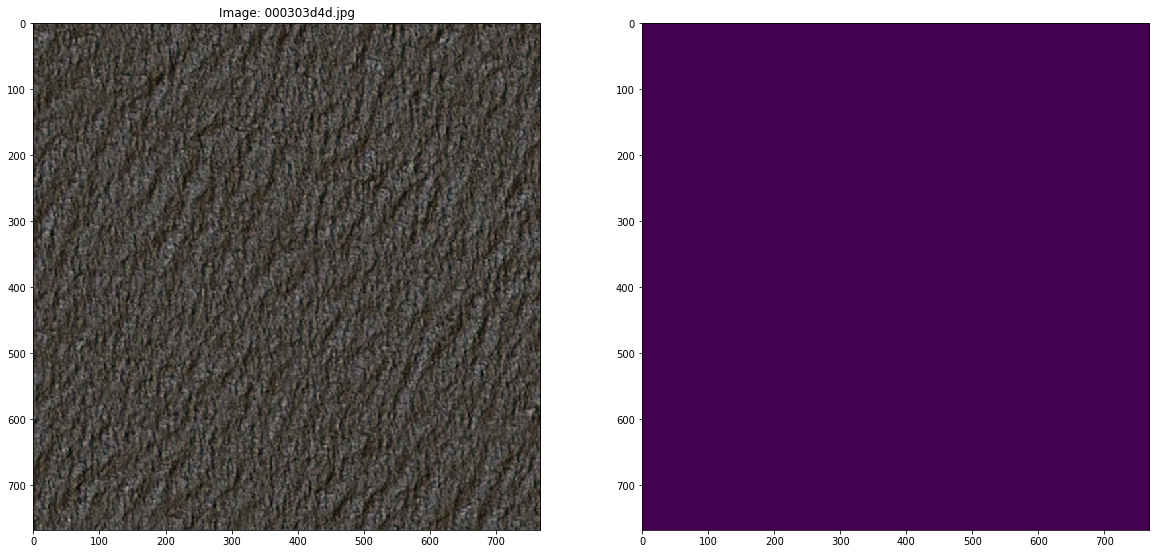

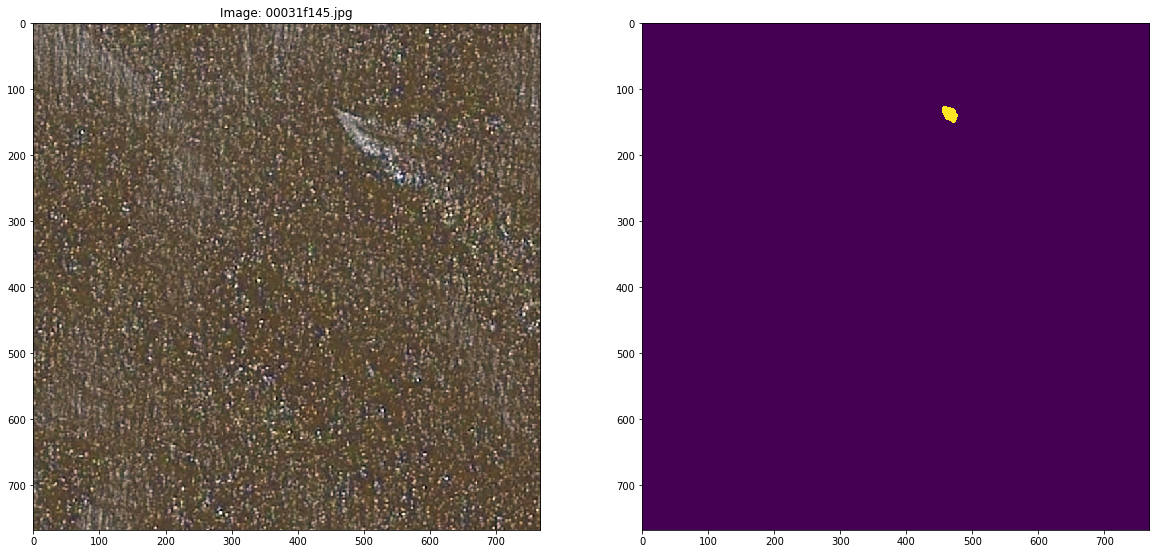

In [ ]:
show_test_result_bulk(oof, '../input/all/', 10)

In [ ]:
kaggle_util.save_result(sub, '../result/sub_fix.csv', competition = 'airbus-ship-detection', send = True, index = False)